# Recurrent Neural Network for Stock Prediction

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance


## 1. Import Libraries and Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import math
from datetime import datetime, timedelta

In [ ]:
np.random.seed(42)


## 2. Choose and Download Stock Data

We choose the stock data of Reliance Industries Limited for training the LSTM model. We set the end date as the current data and download the data of last 5 years.

In [ ]:
stock_symbol = 'RELIANCE.NS'

In [ ]:
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data
print(f"Downloading data for {stock_symbol} from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
print(f"Data downloaded: {len(stock_data)} trading days")



[*********************100%***********************]  1 of 1 completed

Data downloaded: 1236 trading days


In [ ]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2020-04-03,483.925659,509.526647,474.426354,509.526647,41367807
2020-04-07,541.707581,545.255744,494.053824,494.997020,54373624
2020-04-08,535.441956,551.992793,521.002134,529.984913,49880330
2020-04-09,547.928040,553.699471,535.823739,545.255644,33032857
2020-04-13,534.094543,545.704804,529.984882,540.741802,23673784


## 3. Visualize Historical Stock Data

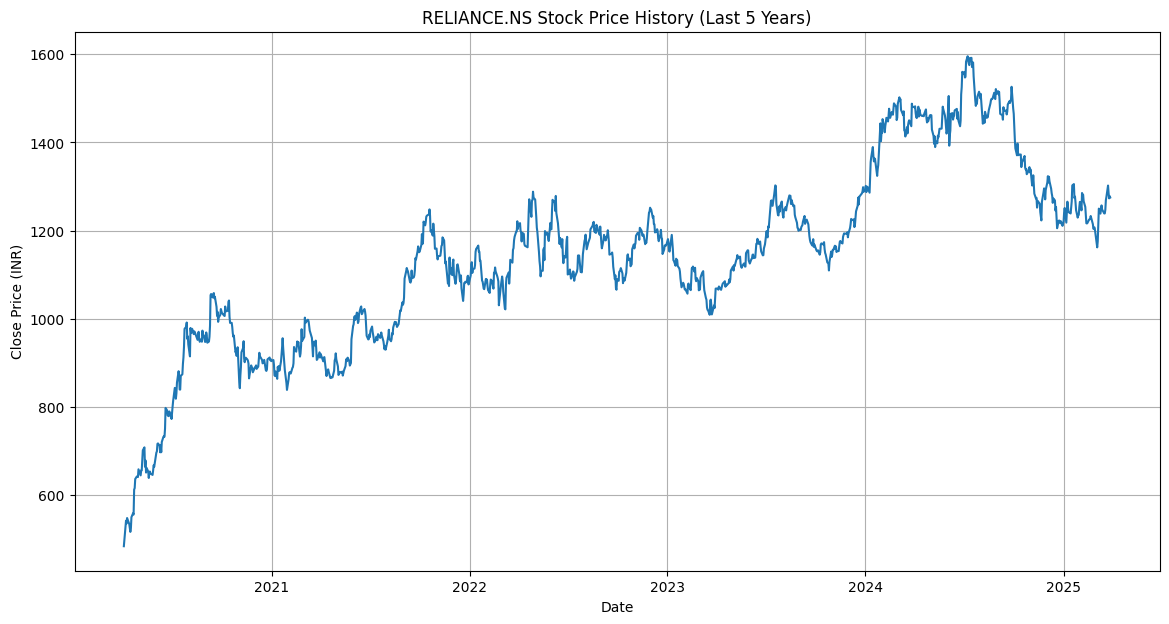

In [ ]:

plt.figure(figsize=(14, 7))
plt.title(f'{stock_symbol} Stock Price History (Last 5 Years)')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.grid(True)
# plt.savefig('stock_history.png')
# plt.close()


## 4. Create Training and Test Datasets

In the dataset, we see that all columns other than Date are numeric and hence Date can be dropped. We make the last 4 months of the dataset as the testing data and earlier ones as the training data

In [ ]:
stock_data_reset = stock_data.reset_index()

features = stock_data.columns.tolist()  # All columns except Date
print(f"Features used for prediction: {features}")

# Split into train and test sets
test_size = 120  # Approximately 4 months of trading days
train_data = stock_data.iloc[:-test_size]
test_data = stock_data.iloc[-test_size:]

print(f"Training data size: {len(train_data)} days")
print(f"Test data size: {len(test_data)} days")


Features used for prediction: [('Close', 'RELIANCE.NS'), ('High', 'RELIANCE.NS'), ('Low', 'RELIANCE.NS'), ('Open', 'RELIANCE.NS'), ('Volume', 'RELIANCE.NS')]
Training data size: 1116 days
Test data size: 120 days


The '**Close**' column is set as the target variable and other features as the predictor variables

In [ ]:
# Scale all features between 0 and 1
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Extract close prices for y
y_train = train_data[['Close']].values
y_test = test_data[['Close']].values

# Scale y data
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Remove 'Close' from X features, as it will be our target
X_features = [col for col in features if col != 'Close']
X_train = train_data[X_features].values
X_test = test_data[X_features].values

# Scale X data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [ ]:
def create_dataset(X_data, y_data, time_steps=60):
    X, y = [], []
    for i in range(len(X_data) - time_steps):
        X.append(X_data[i:(i + time_steps)])
        y.append(y_data[i + time_steps])
    return np.array(X), np.array(y)


## 5. Build LSTM Model Function

We build a model using **3 LSTM layers** of **50** units each with **Dropout** layers between each layer. We use Adam optimizer while training the model. We train the model for 20 epochs.

In [ ]:
def build_lstm_model(time_steps, dropout_rate=0.2, batch_size=32):
    X_train_seq, y_train_seq = create_dataset(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_dataset(X_test_scaled, y_test_scaled, time_steps)

    n_features = X_train_seq.shape[2]

    # Build LSTM model with 3 LSTM layers
    model = Sequential()

    # First LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features)))
    model.add(Dropout(dropout_rate))

    # Second LSTM layer with dropout
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Third LSTM layer with dropout
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(), loss='mean_squared_error')

    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=batch_size, verbose=0)

    train_predict = model.predict(X_train_seq)
    test_predict = model.predict(X_test_seq)

    # Invert predictions back to original scale
    train_predict = scaler_y.inverse_transform(train_predict)
    y_train_inv = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
    test_predict = scaler_y.inverse_transform(test_predict)
    y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    # Calculate RMSE
    train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

    return {
        'model': model,
        'X_test_seq': X_test_seq,
        'y_test_inv': y_test_inv,
        'test_predict': test_predict,
        'y_train_inv': y_train_inv,
        'train_predict': train_predict,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'time_steps': time_steps,
        'dropout_rate': dropout_rate,
        'batch_size': batch_size
    }

## 6. Train Default LSTM Model

Initially, the model is trained with the default parameters


*   Time steps = 60
*   Dropout Rate = 0.2
*   Batch Size = 32

In [ ]:
default_params = {
    'time_steps': 60,
    'dropout_rate': 0.2,
    'batch_size': 32
}

print("\nTraining default model with parameters:", default_params)
default_results = build_lstm_model(**default_params)


Training default model with parameters: {'time_steps': 60, 'dropout_rate': 0.2, 'batch_size': 32}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


In [ ]:
print(f"Default model - Training RMSE: {default_results['train_rmse']:.2f}")
print(f"Default model - Test RMSE: {default_results['test_rmse']:.2f}")

Default model - Training RMSE: 39.09
Default model - Test RMSE: 32.41


## 7. Plot Default Model Results


In [ ]:
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(14, 7))
    plt.title(title)
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price (INR)')
    plt.legend()
    plt.grid(True)


### Plotting the fitted default model on the training dataset


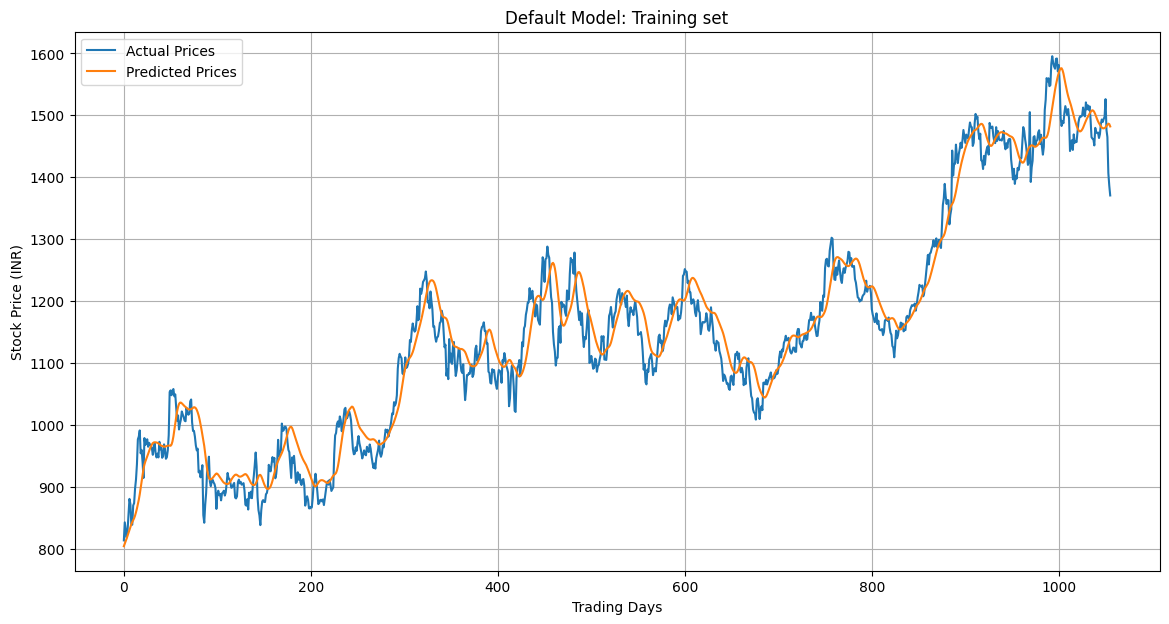

In [ ]:
plot_predictions(
    default_results['y_train_inv'],
    default_results['train_predict'],
    f"Default Model: Training set"
)

### Plotting the fitted default model on the testing dataset


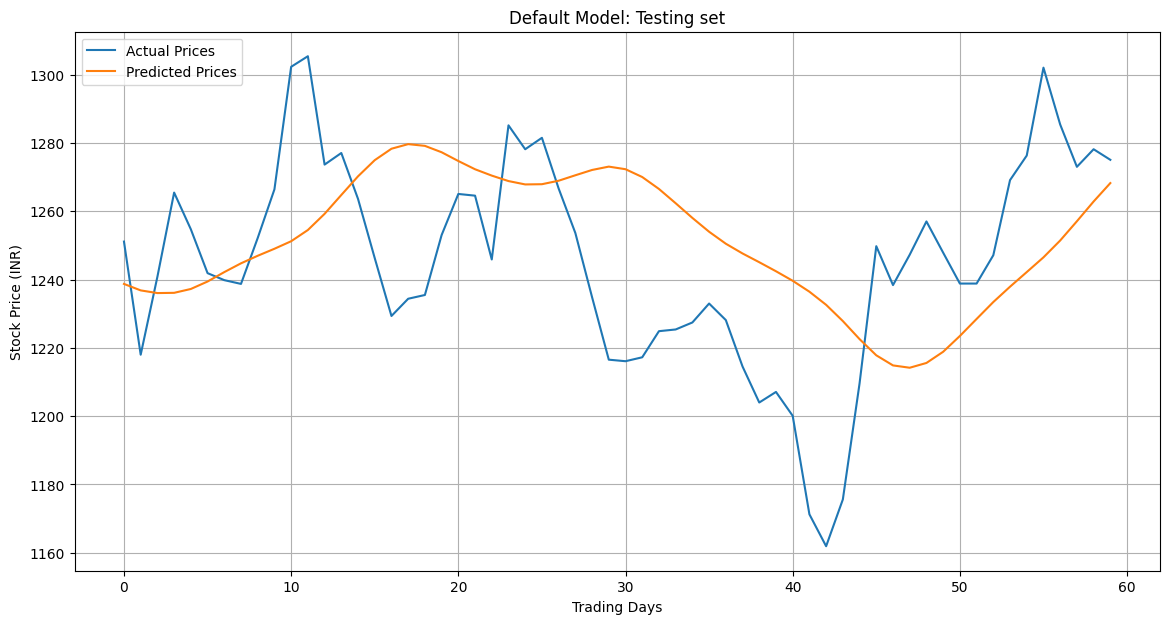

In [ ]:
plot_predictions(
    default_results['y_test_inv'],
    default_results['test_predict'],
    f"Default Model: Testing set"
)

## 8. Optimize Hyperparameters with Grid Search

A 3x3 grid is formed with 3 possible values for each of Time Steps, Dropout Rate and Batch Size. So, overall 27 possible combinations are possible.

In [ ]:
param_grid = {
    'time_steps': [30, 60, 90],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64]
}

# Create all combinations of parameters
grid = list(ParameterGrid(param_grid))
print(f"\nPerforming grid search with {len(grid)} parameter combinations...")


Performing grid search with 27 parameter combinations...


We train the same LSTM model which was earlier built using all possible combinations in the parameter grid

In [ ]:
grid_results = []

# Loop through parameter combinations
for params in grid:
    print(f"Training model with parameters: {params}")
    results = build_lstm_model(**params)
    grid_results.append(results)
    print(f"Test RMSE: {results['test_rmse']:.2f}")

Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.1, 'time_steps': 30}
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test RMSE: 33.22
Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.1, 'time_steps': 60}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Test RMSE: 42.24
Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.1, 'time_steps': 90}
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Test RMSE: 35.96
Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'time_steps': 30}
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test RMSE: 31.38
Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'time_steps': 60}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Test RMSE: 38.98
Training model with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'ti

## 9. Analyze Grid Search Results

The model with the least test RMSE is selected as the best model.

In [ ]:
best_model = min(grid_results, key=lambda x: x['test_rmse'])
print("\nBest model parameters:")
print(f"Time Steps: {best_model['time_steps']}")
print(f"Dropout Rate: {best_model['dropout_rate']}")
print(f"Batch Size: {best_model['batch_size']}")
print(f"Best model - Test RMSE: {best_model['test_rmse']:.2f}")



Best model parameters:
Time Steps: 30
Dropout Rate: 0.2
Batch Size: 16
Best model - Test RMSE: 31.38


### Plotting the fitted best model on the training dataset


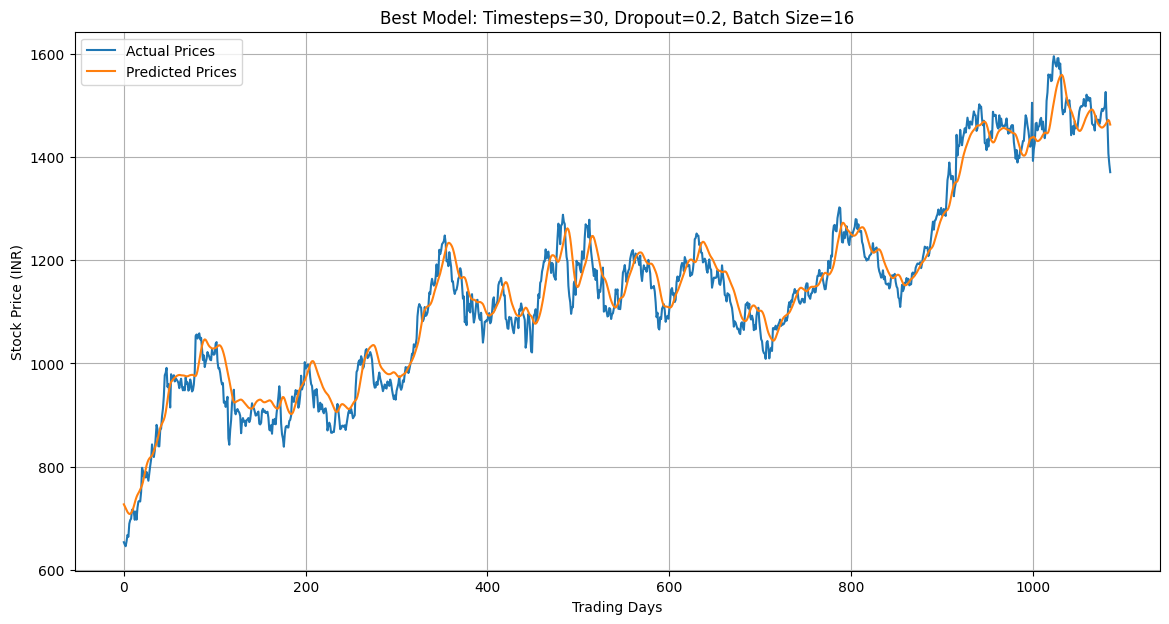

In [ ]:
# Plotting the training set
plot_predictions(
    best_model['y_train_inv'],
    best_model['train_predict'],
    f"Best Model: Timesteps={best_model['time_steps']}, Dropout={best_model['dropout_rate']}, Batch Size={best_model['batch_size']}"
)

### Plotting the fitted best model on the testing dataset


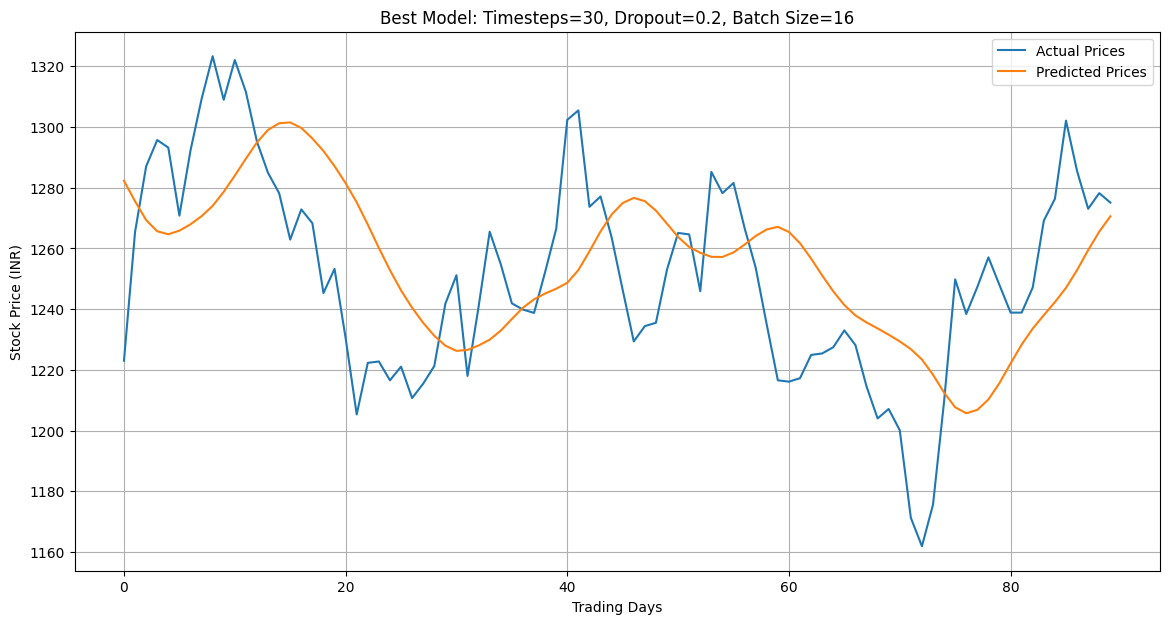

In [ ]:
# Plotting the testing set
plot_predictions(
    best_model['y_test_inv'],
    best_model['test_predict'],
    f"Best Model: Timesteps={best_model['time_steps']}, Dropout={best_model['dropout_rate']}, Batch Size={best_model['batch_size']}"
)


## 10. Compare All Models

The RMSE values of the fitted models using different parameters is plotted.

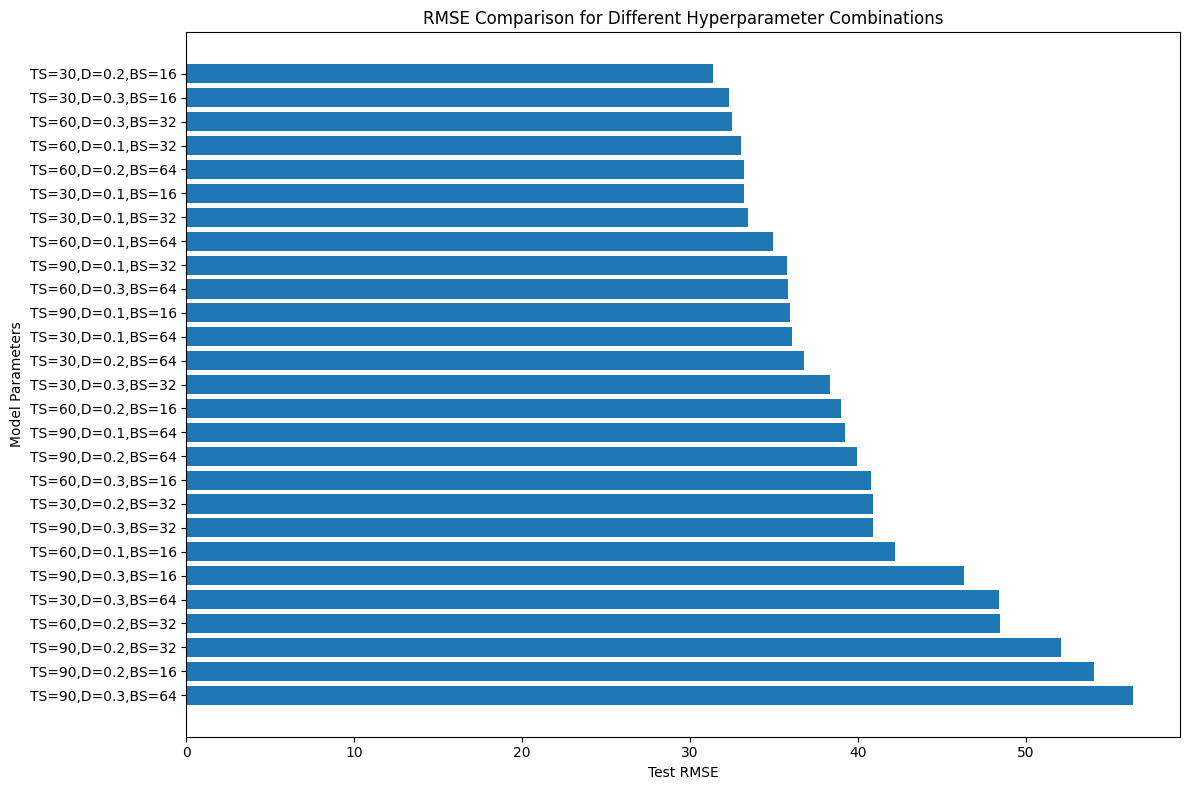

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('RMSE Comparison for Different Hyperparameter Combinations')

# Sort results by test RMSE
sorted_results = sorted(grid_results, key=lambda x: x['test_rmse'])
model_names = [f"TS={r['time_steps']},D={r['dropout_rate']},BS={r['batch_size']}" for r in sorted_results]
rmse_values = [r['test_rmse'] for r in sorted_results]

plt.barh(model_names[::-1], rmse_values[::-1])
plt.xlabel('Test RMSE')
plt.ylabel('Model Parameters')
plt.tight_layout()


We can see that the model with (TS =90, D=0.3, BS=64) performed the worst on the test data, while (TS =30, D=0.2, BS=16) performed the best with the lowest RMSE.

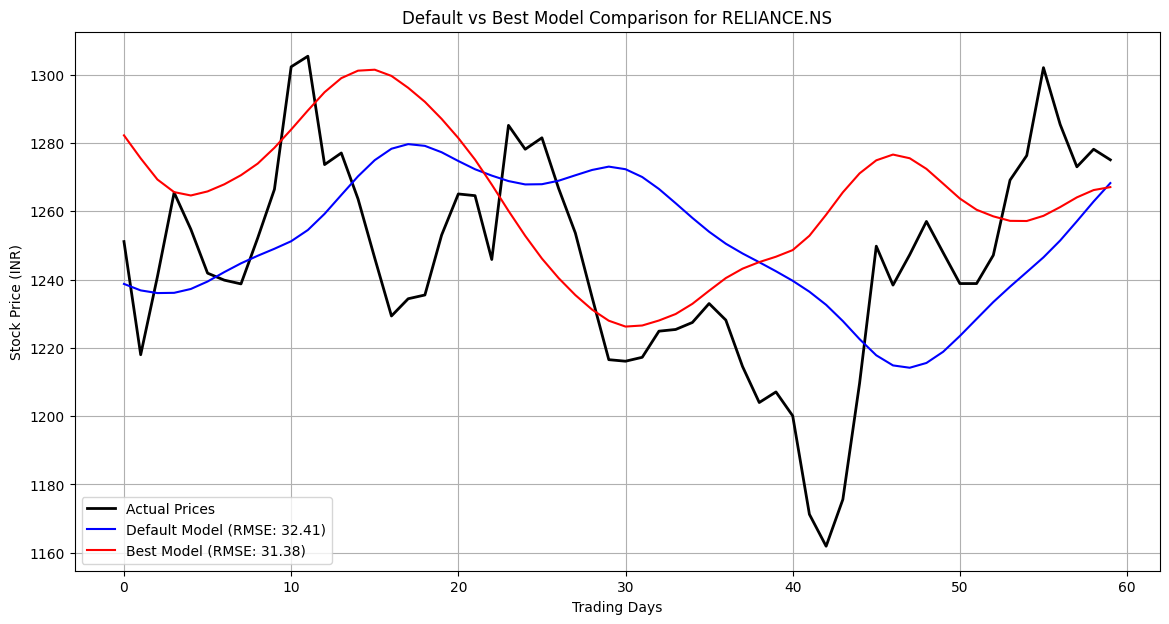

In [ ]:
# Compare default vs best model
plt.figure(figsize=(14, 7))
plt.title(f'Default vs Best Model Comparison for {stock_symbol}')

min_length = min(
    len(default_results['y_test_inv']),
    len(default_results['test_predict']),
    len(best_model['y_test_inv']),
    len(best_model['test_predict'])
)

# Truncate arrays to same length
y_test_actual = default_results['y_test_inv'][:min_length]
default_pred = default_results['test_predict'][:min_length]
best_pred = best_model['test_predict'][:min_length]


plt.plot(y_test_actual, label='Actual Prices', color='black', linewidth=2)
plt.plot(default_pred, label=f'Default Model (RMSE: {default_results["test_rmse"]:.2f})', color='blue')
plt.plot(best_pred, label=f'Best Model (RMSE: {best_model["test_rmse"]:.2f})', color='red')

plt.xlabel('Trading Days')
plt.ylabel('Stock Price (INR)')
plt.legend()
plt.grid(True)


## Conclusions from the LSTM Stock Price Prediction Model

#### Model Performance Comparison
- The best model achieved an RMSE of 31.38, outperforming the default model which had an RMSE of 32.41
- The model with parameters (Time Steps=30, Dropout=0.2, Batch Size=16) performed best among all 27 parameter combinations tested
- The worst-performing model had parameters (Time Steps=90, Dropout=0.3, Batch Size=64) with significantly higher RMSE

#### Hyperparameter Impact Analysis
- **Time Steps**: Shorter time steps (30) worked better than longer sequences (90), suggesting that more recent data has stronger predictive power for this particular stock
- **Dropout Rate**: A moderate dropout rate (0.2) provided optimal regularization, balancing between underfitting and overfitting
- **Batch Size**: Smaller batch sizes (16) allowed for more frequent model updates and better convergence compared to larger batches (64)
- The difference in RMSE between the best and default models (1.03 points) represents approximately a 3.2% improvement

